In [52]:
pip install torchdiffeq

Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install qutip

Note: you may need to restart the kernel to use updated packages.


In [53]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
from qutip import *
from torchdiffeq import odeint
import os
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio.v2 as imageio
from IPython.display import clear_output
device = "cuda:0" if torch.cuda.is_available() else "cpu" 

In [54]:
torch.__version__

'1.13.0'

In [55]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" 

In [56]:
def normalize(a):
	a_oo = a - np.real(a).min()
	return a_oo/np.abs(a_oo).max()

def get_state(theta, phi):
    ket0, ket1 = np.array([[1.],[0.]]), np.array([[0.],[1.]])
    bloch_state = np.cos(theta/2) * ket0 + np.exp(complex(0, phi))*ket1
    return Qobj(bloch_state)

def get_spherical(theta, phi):
    return np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])

def sample_bloch(n_samples=50, rand=True):
    if rand:
        thetas = np.sort(np.pi * np.random.rand(n_samples))
        phis = np.sort(2 * np.pi * np.random.rand(n_samples))
        
    else:
        thetas = np.linspace(0, np.pi, n_samples)
        phis = np.linspace(0, 2 * np.pi, n_samples)
    
    bloch_vec = np.dstack(np.meshgrid(thetas, phis)) # [n_samples, n_samples, 2]
    return bloch_vec.reshape(n_samples * n_samples, 2) # [n_samples^2, 2]

def sample_initial_states(n_samples=50, rand=True):
    " sample initial states "
    bloch_vecs = sample_bloch(n_samples, rand)
    states = [get_state(*bvec) for bvec in bloch_vecs]
    spherical = np.asarray([get_spherical(*bvec) for bvec in bloch_vecs])

    return states, bloch_vecs, spherical

def final_states_to_numpy(states):
    "convert list of quantum objects to numpy array [2, num_time_steps]"
    return np.concatenate([state.full() for state in states], axis=-1)

class StochasticTwoLevelDataset(Dataset):
    def __init__(self, num_batches=30, batched_samples=6, validation_samples=10, start=0, stop=2, last=10, time_steps=300, mc_samples=250, dataset_type='closed'): 
        self.total_time_steps = np.linspace(start, last, time_steps)
        self.initial_states, _, self.spherical = sample_initial_states(batched_samples, rand=True)
        self.validation_points = sample_initial_states(validation_samples, rand=False)
        self.num_per_batch = batched_samples ** 2
        self.num_batches = num_batches
        self.num_trajs = self.num_per_batch * self.num_batches
        self.dataset_type = dataset_type

        if dataset_type == 'closed':
            self.rand_parameters = np.zeros((num_batches, 2))
        elif dataset_type == 'open':
            self.rand_parameters = np.zeros((num_batches, 4))
        expect_data = []
        for i in range(num_batches):
            samp_z = np.random.uniform(1, 2.5, 1)
            samp_x = np.random.uniform(1, 2.5, 1)
            self.rand_parameters[i, 0] = samp_z
            self.rand_parameters[i, 1] = samp_x
            H = samp_z[0] * sigmaz() + samp_x[0] * sigmax()

            if dataset_type == 'closed':
                solve = lambda state : sesolve(H, state, self.total_time_steps, e_ops=[sigmax(), sigmay(), sigmaz()], progress_bar=None)
            elif dataset_type == 'open':
                decay_samp = np.random.uniform(0.1, 0.3, 2)
                self.rand_parameters[i, 2:] = decay_samp
                c_ops = [np.sqrt(decay_samp[0]) * sigmax(), np.sqrt(decay_samp[1]) * sigmaz()]
                solve = lambda state : mesolve(H, state, self.total_time_steps, e_ops=[sigmax(), sigmay(), sigmaz()], c_ops=c_ops)
                
            all_states = [solve(state).expect for state in self.initial_states]
            states = [np.asarray(states, dtype='double') for states in all_states] 
            states = np.asarray([np.column_stack([state[0], state[1], state[2]]) for state in states])
            expect_data.append(states)
            
        self.expect_data = np.asarray(expect_data)
        self.total_expect_data = self.expect_data.reshape(self.num_trajs, time_steps, 3)
        self.train_time_steps = self.total_time_steps[np.where(self.total_time_steps <= stop)]
        self.train_expect_data = self.total_expect_data[:,:self.train_time_steps.shape[0],:]

    def plot_trajs(self):
        for i in range(self.num_batches):
            for j in range(self.num_per_batch):
                ts = self.time_steps
                fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

                ax1.plot(ts, self.expect_data[i, j, :, 0])
                ax1.set_ylim(-1, 1)
                ax1.set_ylabel('$\sigma_x$')

                ax2.plot(ts, self.expect_data[i, j, :, 1])
                ax2.set_ylim(-1, 1)
                ax2.set_ylabel('$\sigma_y$')

                ax3.plot(ts, self.expect_data[i, j, :, 2])
                ax3.set_ylim(-1, 1)
                ax3.set_ylabel('$\sigma_z$')
                if self.dataset_type == 'closed':
                    ax3.set_xlabel('H = {}z + {}x'.format(self.rand_parameters[i, 0], self.rand_parameters[i, 1]))
                else:
                    ax3.set_xlabel('H = {}z + {}x decay: {} {}'.format(*self.rand_parameters[i]))

                plt.savefig('plots/stochastic_closed_noise/traj_{}_{}.png'.format(i, j))
                plt.close(fig)

    def render_initial_states(self, directory):
        bloch = Bloch()
        colors = normalize(self.spherical)
        bloch.point_color = colors
        bloch.add_points([self.spherical[:, 0], self.spherical[:, 1], self.spherical[:, 2]], 'm')
        bloch.save(directory)

# two qubit functions

In [57]:
from tqdm import trange

In [58]:
class LatentODEfunc(nn.Module):
    
    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.nfe = 0
        self.ode = nn.Sequential(
            nn.Linear(latent_dim, nhidden),
            nn.ELU(inplace=True),
            nn.Linear(nhidden, nhidden),
            nn.ELU(inplace=True),
            nn.Linear(nhidden, nhidden),
            nn.ELU(inplace=True),
            nn.Linear(nhidden, 2* nhidden),
            nn.ELU(inplace = True),
            nn.Linear(2*nhidden, nhidden),
            nn.ELU(inplace=True),
            nn.Linear(nhidden, latent_dim)

        )

    def forward(self, t, x):
        self.nfe += 1
        result = self.ode(x)
        return result.to(device)
    
class RecognitionRNN(nn.Module):
    
    def __init__(self, latent_dim=6, obs_dim=3, nhidden=48, nbatch=1):
        super().__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.lstm = nn.LSTM(input_size=obs_dim, hidden_size=nhidden, num_layers=1)
        self.fc = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        out, (h, c) = self.lstm(x.unsqueeze(0), (h.unsqueeze(0), torch.zeros_like(h).unsqueeze(0)))
        out = self.fc(h.squeeze(0))
        return out, h.squeeze(0)

    def initHidden(self, batch=0):
        if batch == 0:
            return torch.zeros(self.nbatch, self.nhidden).to(device)
        else:
            return torch.zeros(batch, self.nhidden).to(device)



class Decoder(nn.Module):
    
    def __init__(self, latent_dim=6, obs_dim=3, nhidden=48, extra=False):
        super().__init__()
        self.extra = extra
        self.lstm1 = nn.LSTM(input_size=latent_dim, hidden_size=nhidden, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=nhidden, hidden_size=nhidden, num_layers=1, batch_first=True)
        self.fc = nn.Linear(nhidden, obs_dim)
        self.tanh = nn.Tanh()

    def forward(self, z):
        out, _ = self.lstm1(z)
        out = self.tanh(out)
        out, _ = self.lstm2(out)
        out = self.tanh(out)
        out = self.fc(out)
        return out.to(device)

def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(device)
    const = torch.log(const)
    return -.5 * (const + logvar.to(device) + (x - mean) ** 2. / torch.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1).to(device)
    v2 = torch.exp(lv2).to(device)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl




class latent_ode(torch.nn.Module):
    def __init__(self,obs_dim=2, latent_dim=4, nhidden=20, rnn_nhidden=25, data = None, lr=1e-2, batch=1000, beta=1, extra_decode=False):
        super().__init__()
        self.obs_dim = obs_dim
        self.latent_dim = latent_dim
        self.nhidden = nhidden
        self.rnn_nhidden = rnn_nhidden
        self.beta = beta
        self.data = data
        self.epsilon = None
        self.func = LatentODEfunc(latent_dim, nhidden)
        self.rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, batch)
        self.dec = Decoder(latent_dim, obs_dim, nhidden, extra=extra_decode)
        self.params = (list(self.func.parameters()) + list(self.dec.parameters()) + list(self.rec.parameters()))
        self.lr = lr
        self.optimizer = optim.Adam(self.params, lr=self.lr)


    def train(self, trajs, ts, num_epochs):
        # dataset parameters
        num_ts = ts.size(0)
        beta = self.beta
        bloch = qutip.Bloch()
        os.makedirs('./plots/train',exist_ok = True)
        for itr in trange(num_epochs):
            self.rec.to(device)
            self.func.to(device)
            self.optimizer.zero_grad()
            h = self.rec.initHidden()
            self.rec.to(device)
            for t in reversed(range(num_ts)):
                obs = trajs[:, t, :]
                out, h = self.rec.forward(obs, h)
            qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
            qz0_mean = qz0_mean.to(device)
            qz0_logvar = qz0_logvar.to(device)
            epsilon = torch.randn(qz0_mean.size()).to(device)
            z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
            z0 = z0.to(device)

            # forward in time and solve ode for reconstructions
            pred_z = odeint(self.func, z0, ts).permute(1, 0, 2)
            pred_x = self.dec(pred_z)
            pred_x = pred_x.to(device)

            # compute loss
            noise_std_ = torch.zeros(pred_x.size()) + 0.3
            noise_logvar = 2. * torch.log(noise_std_)
            noise_logvar = noise_logvar.to(device)
            logpx = log_normal_pdf(
                trajs, pred_x, noise_logvar).sum(-1).sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = beta * normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            lagrange = (1 - pred_x[:,:,0]**2 - pred_x[:,:,1]**2 - pred_x[:,:,2]**2).sum(-1)
            loss = torch.mean(-logpx + analytic_kl+ torch.abs(lagrange), dim=0).to(device)
            loss.backward()
            av_mse, *_ = self.MSE(trajs, ts)
            self.optimizer.step()
            metrics['Elbo'].append(loss.to('cpu').detach().numpy())
            metrics['train_loss'].append(av_mse)
            if itr == num_epochs:
                self.epsilon = epsilon
            print('Epoch: {}, elbo: {:.4f}, mse: {:.4f}'.format(itr, loss, av_mse))
            
            if  itr % 300 == 0:
                clear_output(True)
                coor0 = pred_x.cpu().detach().numpy()
                x0 = coor0[0,:,0]
                y0 =  coor0[0,:,1]
                z0 =  coor0[0,:,2]
                coor1 = trajs.cpu().detach().numpy()
                x1 = coor1[0,:,0]
                y1 =  coor1[0,:,1]
                z1 =  coor1[0,:,2]
                bloch.render()
                bloch.add_points([x1,y1,z1])
                bloch.add_points([x0,y0,z0])
                bloch.show()
                
                plt.figure(figsize=[12, 4])
                plt.subplot(1,2,1)
                plt.plot(metrics['train_loss'], label='MSE')
                plt.legend()
                plt.grid()
                plt.subplot(1,2,2)
                plt.plot(metrics['Elbo'], label='Elbo')
                plt.legend()
                plt.grid()
                plt.show()
                plt.savefig('./plots/train/train_cicle{}'.format(itr))
                bloch.clear()

                








    def encode(self, trajs, ts, reconstruct=True):
        if (reconstruct):
            with torch.no_grad():
                num_ts = ts.size(0)
                # sample from trajectorys' approx. posterior
                h = self.rec.initHidden(batch=trajs.shape[0]).to(device)
                for t in reversed(range(num_ts)):
                    obs = trajs[:, t, :]
                    out, h = self.rec.forward(obs, h)
                qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
                z0 = qz0_mean #self.epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
        else:
            with torch.no_grad():
                num_ts = ts.size(0)
                # sample from trajectorys' approx. posterior
                h = self.rec.initHidden(batch=trajs.shape[0])
                for t in reversed(range(num_ts)):
                    obs = trajs[:, t, :]
                    out, h = self.rec.forward(obs, h)
                qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
                epsilon = torch.randn(qz0_mean.size()).to(device)
                z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        return z0.to(device)

    def decode(self, z0, ts):
        with torch.no_grad():
            if len(z0.shape) == 1:
                pred_z = odeint(self.func, z0, ts)
            else:
                pred_z = odeint(self.func, z0, ts).permute(1, 0, 2)
            pred_x = self.dec(pred_z)
        return pred_x.to(device)

    def latent_dynamics(self, trajs, enc_ts, dec_ts, recontruct=True):
        z0 = self.encode(trajs, enc_ts, recontruct)
        print('z0',z0.shape)
        with torch.no_grad():
            if len(z0.shape) == 1:
                pred_z = odeint(self.func, z0, dec_ts)
            else:
                pred_z = odeint(self.func, z0, dec_ts).permute(1, 0, 2)
        return pred_z.to(device)


    def MSE(self, trajs, train_ts):
        z0 = self.encode(trajs, train_ts)
        pred_x = self.decode(z0, train_ts)

        mse_errors = np.mean((trajs.cpu().numpy() - pred_x.cpu().numpy()) ** 2, axis=1)
        mse_errors = np.mean(mse_errors, axis=1)
        avg_mse = np.mean(mse_errors)

        return avg_mse, mse_errors

In [59]:
def save_dataset(data, dataset_name):
    torch.save(data, '/kaggle/working/{}.pt'.format(dataset_name))

def load_dataset():
    return torch.load('/kaggle/working/closed-0.pt')

In [60]:
seed = 0
types = 'closed'
epochs = 7500
obs_dim = 3
latent_dim = 6
rnn_nhidden = 48
nhidden = 48
lr = 3e-3
metrics = {'train_loss': [], 'Elbo': [] }

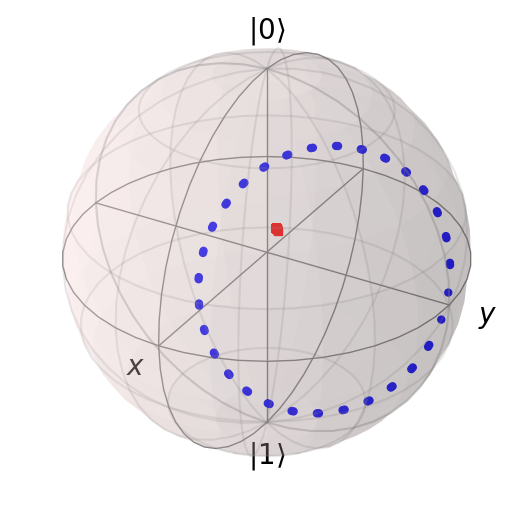

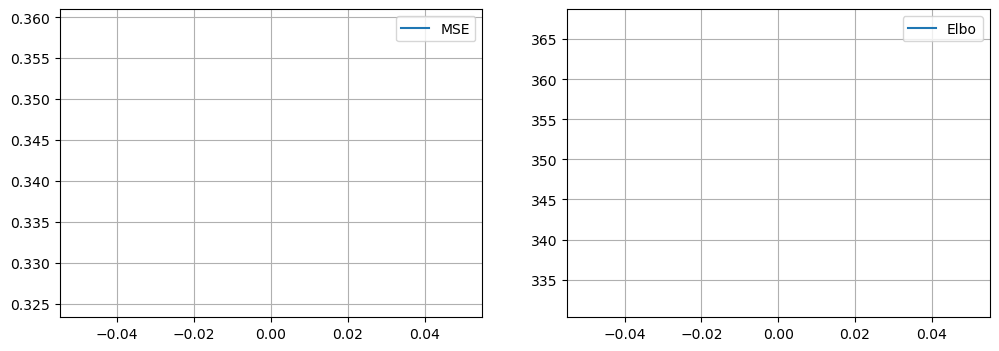

  0%|          | 2/7500 [00:01<1:27:45,  1.42it/s]

Epoch: 1, elbo: 334.3157, mse: 0.3269


  0%|          | 3/7500 [00:01<1:00:41,  2.06it/s]

Epoch: 2, elbo: 320.0470, mse: 0.3131


  0%|          | 4/7500 [00:02<48:21,  2.58it/s]  

Epoch: 3, elbo: 306.3247, mse: 0.3003


  0%|          | 5/7500 [00:02<41:47,  2.99it/s]

Epoch: 4, elbo: 293.9937, mse: 0.2901


  0%|          | 6/7500 [00:02<38:42,  3.23it/s]

Epoch: 5, elbo: 285.8511, mse: 0.2874


  0%|          | 7/7500 [00:02<36:42,  3.40it/s]

Epoch: 6, elbo: 290.5593, mse: 0.3024


  0%|          | 8/7500 [00:03<35:28,  3.52it/s]

Epoch: 7, elbo: 292.2469, mse: 0.3058


  0%|          | 9/7500 [00:03<34:09,  3.65it/s]

Epoch: 8, elbo: 288.4894, mse: 0.2985


  0%|          | 10/7500 [00:03<33:36,  3.72it/s]

Epoch: 9, elbo: 284.8356, mse: 0.2915


  0%|          | 11/7500 [00:03<32:48,  3.80it/s]

Epoch: 10, elbo: 283.8709, mse: 0.2877


  0%|          | 12/7500 [00:04<31:51,  3.92it/s]

Epoch: 11, elbo: 284.2235, mse: 0.2861


  0%|          | 13/7500 [00:04<31:05,  4.01it/s]

Epoch: 12, elbo: 284.6933, mse: 0.2855


  0%|          | 14/7500 [00:04<30:48,  4.05it/s]

Epoch: 13, elbo: 285.1627, mse: 0.2854


  0%|          | 15/7500 [00:04<30:16,  4.12it/s]

Epoch: 14, elbo: 284.9981, mse: 0.2853


  0%|          | 16/7500 [00:05<29:55,  4.17it/s]

Epoch: 15, elbo: 284.7634, mse: 0.2851


  0%|          | 17/7500 [00:05<29:37,  4.21it/s]

Epoch: 16, elbo: 284.5759, mse: 0.2849


  0%|          | 18/7500 [00:05<29:39,  4.20it/s]

Epoch: 17, elbo: 283.8285, mse: 0.2847


  0%|          | 19/7500 [00:05<29:26,  4.23it/s]

Epoch: 18, elbo: 282.8677, mse: 0.2846


  0%|          | 20/7500 [00:05<29:07,  4.28it/s]

Epoch: 19, elbo: 282.7580, mse: 0.2847


  0%|          | 21/7500 [00:06<29:05,  4.28it/s]

Epoch: 20, elbo: 281.4719, mse: 0.2849


  0%|          | 22/7500 [00:06<33:18,  3.74it/s]

Epoch: 21, elbo: 281.2527, mse: 0.2851


  0%|          | 23/7500 [00:06<32:23,  3.85it/s]

Epoch: 22, elbo: 280.3188, mse: 0.2849


  0%|          | 24/7500 [00:07<31:42,  3.93it/s]

Epoch: 23, elbo: 279.5238, mse: 0.2840


  0%|          | 25/7500 [00:07<31:02,  4.01it/s]

Epoch: 24, elbo: 278.9679, mse: 0.2822


  0%|          | 26/7500 [00:07<30:30,  4.08it/s]

Epoch: 25, elbo: 275.1058, mse: 0.2792


  0%|          | 27/7500 [00:07<29:51,  4.17it/s]

Epoch: 26, elbo: 272.7763, mse: 0.2744


  0%|          | 28/7500 [00:07<29:56,  4.16it/s]

Epoch: 27, elbo: 268.5871, mse: 0.2666


  0%|          | 29/7500 [00:08<30:09,  4.13it/s]

Epoch: 28, elbo: 264.1476, mse: 0.2540


  0%|          | 30/7500 [00:08<31:12,  3.99it/s]

Epoch: 29, elbo: 256.4455, mse: 0.2376


  0%|          | 31/7500 [00:08<32:30,  3.83it/s]

Epoch: 30, elbo: 247.6271, mse: 0.2266


  0%|          | 32/7500 [00:09<33:49,  3.68it/s]

Epoch: 31, elbo: 243.5466, mse: 0.2239


  0%|          | 33/7500 [00:09<35:36,  3.50it/s]

Epoch: 32, elbo: 230.5652, mse: 0.2226


  0%|          | 34/7500 [00:09<36:38,  3.40it/s]

Epoch: 33, elbo: 221.7989, mse: 0.2193


  0%|          | 35/7500 [00:09<36:10,  3.44it/s]

Epoch: 34, elbo: 216.9666, mse: 0.2165


  0%|          | 36/7500 [00:10<35:08,  3.54it/s]

Epoch: 35, elbo: 211.5955, mse: 0.2157


  0%|          | 37/7500 [00:10<34:27,  3.61it/s]

Epoch: 36, elbo: 208.4819, mse: 0.2138


  1%|          | 38/7500 [00:10<34:37,  3.59it/s]

Epoch: 37, elbo: 204.2743, mse: 0.2143


  1%|          | 39/7500 [00:11<34:13,  3.63it/s]

Epoch: 38, elbo: 204.2545, mse: 0.2173


  1%|          | 40/7500 [00:11<34:02,  3.65it/s]

Epoch: 39, elbo: 202.8466, mse: 0.2191


  1%|          | 41/7500 [00:11<33:53,  3.67it/s]

Epoch: 40, elbo: 202.0415, mse: 0.2181


  1%|          | 42/7500 [00:11<34:45,  3.58it/s]

Epoch: 41, elbo: 199.4995, mse: 0.2144


  1%|          | 43/7500 [00:12<34:48,  3.57it/s]

Epoch: 42, elbo: 202.1055, mse: 0.2143


  1%|          | 44/7500 [00:12<35:28,  3.50it/s]

Epoch: 43, elbo: 200.5845, mse: 0.2118


  1%|          | 45/7500 [00:12<35:38,  3.49it/s]

Epoch: 44, elbo: 198.2023, mse: 0.2081


  1%|          | 46/7500 [00:13<35:49,  3.47it/s]

Epoch: 45, elbo: 195.7196, mse: 0.2065


  1%|          | 47/7500 [00:13<36:12,  3.43it/s]

Epoch: 46, elbo: 192.3821, mse: 0.2061


  1%|          | 48/7500 [00:13<36:50,  3.37it/s]

Epoch: 47, elbo: 191.5482, mse: 0.2061


  1%|          | 49/7500 [00:13<37:02,  3.35it/s]

Epoch: 48, elbo: 185.9328, mse: 0.2009


  1%|          | 50/7500 [00:14<38:08,  3.25it/s]

Epoch: 49, elbo: 182.9453, mse: 0.1950


  1%|          | 51/7500 [00:14<38:58,  3.19it/s]

Epoch: 50, elbo: 177.6564, mse: 0.1893


  1%|          | 52/7500 [00:14<40:16,  3.08it/s]

Epoch: 51, elbo: 172.4348, mse: 0.1836


  1%|          | 53/7500 [00:15<41:06,  3.02it/s]

Epoch: 52, elbo: 168.3302, mse: 0.1789


  1%|          | 54/7500 [00:15<42:01,  2.95it/s]

Epoch: 53, elbo: 158.7411, mse: 0.1748


  1%|          | 55/7500 [00:16<42:49,  2.90it/s]

Epoch: 54, elbo: 154.4240, mse: 0.1739


  1%|          | 56/7500 [00:16<42:34,  2.91it/s]

Epoch: 55, elbo: 150.9644, mse: 0.1728


  1%|          | 57/7500 [00:16<43:25,  2.86it/s]

Epoch: 56, elbo: 142.0660, mse: 0.1669


  1%|          | 58/7500 [00:17<44:02,  2.82it/s]

Epoch: 57, elbo: 142.2440, mse: 0.1641


  1%|          | 59/7500 [00:17<47:55,  2.59it/s]

Epoch: 58, elbo: 139.7429, mse: 0.1642


  1%|          | 60/7500 [00:17<47:33,  2.61it/s]

Epoch: 59, elbo: 151.2508, mse: 0.1743


  1%|          | 61/7500 [00:18<46:45,  2.65it/s]

Epoch: 60, elbo: 133.6888, mse: 0.1615


  1%|          | 62/7500 [00:18<47:19,  2.62it/s]

Epoch: 61, elbo: 138.2914, mse: 0.1678


  1%|          | 63/7500 [00:19<46:46,  2.65it/s]

Epoch: 62, elbo: 132.6640, mse: 0.1615


  1%|          | 64/7500 [00:19<47:12,  2.63it/s]

Epoch: 63, elbo: 133.0142, mse: 0.1612


  1%|          | 65/7500 [00:19<47:18,  2.62it/s]

Epoch: 64, elbo: 133.6734, mse: 0.1629


  1%|          | 66/7500 [00:20<50:26,  2.46it/s]

Epoch: 65, elbo: 131.4798, mse: 0.1590


  1%|          | 67/7500 [00:20<57:15,  2.16it/s]

Epoch: 66, elbo: 131.4591, mse: 0.1590


  1%|          | 68/7500 [00:21<1:00:02,  2.06it/s]

Epoch: 67, elbo: 131.6497, mse: 0.1599


  1%|          | 69/7500 [00:21<57:17,  2.16it/s]  

Epoch: 68, elbo: 130.2135, mse: 0.1611


  1%|          | 70/7500 [00:22<55:27,  2.23it/s]

Epoch: 69, elbo: 127.3296, mse: 0.1568


  1%|          | 71/7500 [00:22<55:07,  2.25it/s]

Epoch: 70, elbo: 127.7550, mse: 0.1568


  1%|          | 72/7500 [00:23<54:48,  2.26it/s]

Epoch: 71, elbo: 126.9185, mse: 0.1548


  1%|          | 73/7500 [00:23<55:12,  2.24it/s]

Epoch: 72, elbo: 124.3925, mse: 0.1540


  1%|          | 74/7500 [00:24<56:02,  2.21it/s]

Epoch: 73, elbo: 126.5088, mse: 0.1565


  1%|          | 75/7500 [00:24<56:30,  2.19it/s]

Epoch: 74, elbo: 124.4093, mse: 0.1562


  1%|          | 76/7500 [00:25<57:06,  2.17it/s]

Epoch: 75, elbo: 123.4381, mse: 0.1560


  1%|          | 77/7500 [00:25<58:09,  2.13it/s]

Epoch: 76, elbo: 123.2885, mse: 0.1569


  1%|          | 78/7500 [00:25<59:05,  2.09it/s]

Epoch: 77, elbo: 123.6741, mse: 0.1582


  1%|          | 79/7500 [00:26<59:54,  2.06it/s]

Epoch: 78, elbo: 122.3253, mse: 0.1581


  1%|          | 80/7500 [00:26<1:00:02,  2.06it/s]

Epoch: 79, elbo: 123.9705, mse: 0.1555


  1%|          | 81/7500 [00:27<59:53,  2.06it/s]  

Epoch: 80, elbo: 122.4046, mse: 0.1537


  1%|          | 82/7500 [00:27<1:00:19,  2.05it/s]

Epoch: 81, elbo: 123.3259, mse: 0.1530


  1%|          | 83/7500 [00:28<1:04:11,  1.93it/s]

Epoch: 82, elbo: 121.9824, mse: 0.1529


  1%|          | 84/7500 [00:29<1:03:55,  1.93it/s]

Epoch: 83, elbo: 122.4151, mse: 0.1527


  1%|          | 85/7500 [00:29<1:04:00,  1.93it/s]

Epoch: 84, elbo: 120.6061, mse: 0.1530


  1%|          | 86/7500 [00:30<1:02:46,  1.97it/s]

Epoch: 85, elbo: 122.1723, mse: 0.1530


  1%|          | 87/7500 [00:30<1:00:53,  2.03it/s]

Epoch: 86, elbo: 120.6304, mse: 0.1514


  1%|          | 88/7500 [00:30<58:29,  2.11it/s]  

Epoch: 87, elbo: 120.4563, mse: 0.1505


  1%|          | 89/7500 [00:31<56:23,  2.19it/s]

Epoch: 88, elbo: 121.1606, mse: 0.1497


In [ ]:
if __name__ == "__main__":
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # initializing the dataset
    data = StochasticTwoLevelDataset(dataset_type= types)
    save_dataset(data, '{}-{}'.format(types, seed))
    print('dataset {}-{} saved'.format(types, seed))

    #initializing the model
    trajs = torch.from_numpy(data.train_expect_data).float().to(device)
    ts = torch.from_numpy(data.train_time_steps).float().to(device)
    model = latent_ode(obs_dim=obs_dim, latent_dim= latent_dim, nhidden=nhidden, 
        rnn_nhidden=rnn_nhidden, data = data, lr=lr, batch=data.train_expect_data.shape[0])
    model.to(device)
    model.train(trajs, ts, epochs)
    

In [12]:
torch.save(model.state_dict(),'test_1' )

In [13]:
model1 = latent_ode(obs_dim=obs_dim, latent_dim= latent_dim, nhidden=nhidden, 
        rnn_nhidden=rnn_nhidden, data = data, lr=lr, batch=data.train_expect_data.shape[0])
model1.to(device) 
model1.load_state_dict(torch.load('/kaggle/working/test_1'))

<All keys matched successfully>

In [14]:
bloch = qutip.Bloch()


In [15]:
data = load_dataset()

In [16]:
n = data.total_expect_data.shape[0]
ts = torch.from_numpy(data.total_time_steps).float().to(device)
idxe = np.where(np.logical_and(data.total_time_steps >= 2, data.total_time_steps <= 6))[0]
idxt = np.where(data.total_time_steps <= 2)[0]
rands = np.random.randint(0, n, 20)
np_trajs = data.total_expect_data[0:10]
trajs = torch.from_numpy(np_trajs).float().to(device)


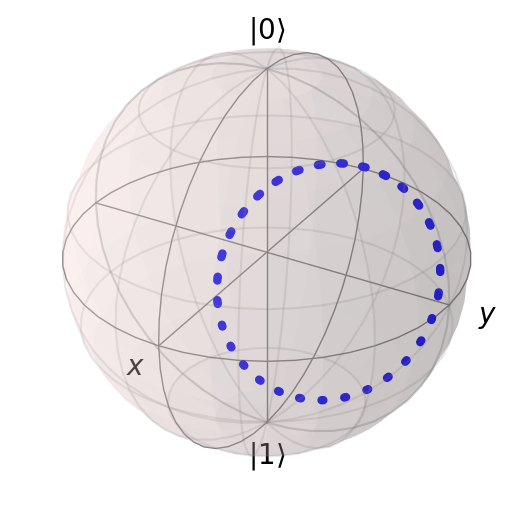

In [40]:
bloch = qutip.Bloch()
a1 = np_trajs[1,:80,0]
b1 = np_trajs[1,:80,1]
c1 = np_trajs[1,:80,2]
bloch.add_points([a1,b1,c1]) 
#bloch.add_points([a,b,c]) 
bloch.show()

In [ ]:
xm = model.decode(torch.randn(10, 6).to(device), ts).to('cpu').numpy()
xm.shape

In [ ]:
bloch.render()
a = xm[7,:,0]
b = xm[7,:,1]
c = xm[7,:,2]
bloch.add_points([a,b,c]) 
bloch.show()

 

In [37]:
mod = xm[0,:,0]**2 +xm[0,:,1]**2+xm[0,:,2]**2

In [38]:
mod

array([0.89327323, 0.88483596, 0.8819011 , 0.8841985 , 0.8912835 ,
       0.90264416, 0.9172891 , 0.9329582 , 0.94642764, 0.9555466 ,
       0.96234334, 0.9703071 , 0.97910285, 0.9853276 , 0.9875286 ,
       0.98839563, 0.9905407 , 0.99378943, 0.9954736 , 0.9925401 ,
       0.98376584, 0.9702922 , 0.95448375, 0.93889725, 0.9266214 ,
       0.9216979 , 0.9278537 , 0.94557273, 0.97058034, 0.9961703 ,
       1.0151702 , 1.021906  , 1.0163715 , 1.0070202 , 1.0036924 ,
       1.0094168 , 1.0234957 , 1.0465546 , 1.0802933 , 1.1237196 ,
       1.1724403 , 1.2220973 , 1.2645247 , 1.2922579 , 1.3118067 ,
       1.3241882 , 1.3259547 , 1.3133748 , 1.2810526 , 1.2252487 ,
       1.1555712 , 1.0918555 , 1.043657  , 1.0090446 , 0.9835025 ,
       0.96414995, 0.9493904 , 0.9376992 , 0.92733353, 0.91735625,
       0.9078262 , 0.89928937, 0.8930721 , 0.8909092 , 0.89435494,
       0.9022093 , 0.90891576, 0.9144865 , 0.923828  , 0.93619406,
       0.94485074, 0.9482285 , 0.94138587, 0.9316115 , 0.92838

In [ ]:
mod_norm = trajs[0,:,0]**2 +trajs[0,:,1]**2+trajs[0,:,2]**2

In [ ]:
mod_norm